<a href="https://colab.research.google.com/github/cellatlas/cellatlas/blob/main/docs/QC_MAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
title: QC Matrix
date: 2024-07-07
authors:
  - name: A. Sina Booeshaghi
---

Preprocessing produces count matrices that can also be QC'ed. Below are important count matrix level QC measures that can be useful for assessing the quality of the data.

We will use the [`mx`](https://github.com/cellatlas/mx/) tool to generate these matrix level QC metrics. First install `mx`:

In [1]:
!pip --quiet install git+https://github.com/cellatlas/mx/
!git clone https://github.com/cellatlas/cellatlas.git
!gunzip cellatlas/examples/CRX102288/raw/*

!gunzip cellatlas/examples/CRX102288/raw/*
!ln -s cellatlas/examples/CRX102288/raw/barcodes.txt .
!ln -s cellatlas/examples/CRX102288/raw/genes.txt .
!ln -s cellatlas/examples/CRX102288/raw/matrix.mtx .
!ln -s cellatlas/examples/CRX102288/observation.json .

  Cloning https://github.com/cellatlas/mx/ to /tmp/pip-req-build-tmlajfr3
  Running command git clone --filter=blob:none --quiet https://github.com/cellatlas/mx/ /tmp/pip-req-build-tmlajfr3
  Resolved https://github.com/cellatlas/mx/ to commit 1ce644679b95006ed3584baaa28652a94c48243f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 63.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 79.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 41.2 MB/s 

In [5]:
!head observation.json

{
    "observation_id": "CRX102288",
    "doi": "https://doi.org/10.1038/s41421-020-0168-9",
    "species": "homo_sapiens",
    "organ": "blood",
    "name": "covid,infected,early,recovery,stage",
    "description": "PBMCs",
    "technology": "10xv2",
    "links": [
        {


# Matrix-level metrics

By way of example, here are whole matrix level measures that can be used to QC.

- **ncells**: The number of barcodes quantified in the matrix
  - Too low and there was an issue with barcode diversity or error-correction to an incorrect onlist
- **ngenes**: The number of genes quantified in the matrix
  - This will often be equal to the number of genes used to construct the alignment index
- **nvals**: The number of entries in the matrix that are non-zero
  - Often a measure for the diversity of barcode-umi pairs in the library
- **density**: `nvals/(ncells*ngenes)`
  - Can be thought of as an efficiency measure of umi capture
- **avg_per_cell**: The average number of counts per cell
- **avg_per_gene**: The average number of counts per gene
- **min_cell**: The number of counts for the cell with the fewest counts
- **max_cell**: The number of counts for the cell with the most counts
- **total_count**: The sum of the counts in the count matrix
- **overdispersion**: `sigma^2 = mu + alpha*mu`, computed on the genes

## Command-line

Then navigate to where you have your matrix files (note the matrix orientation here is `cells x genes`) and run the `mx inspect` command:

In [6]:
!mx inspect -o inspect.json -gi genes.txt -a all -bi barcodes.txt matrix.mtx

Your json file will look like something like this

In [7]:
!cat inspect.json

{"ncells": 12531, "ngenes": 60623, "nvals": 19302558, "density": 0.025409242143634356, "avg_counts_per_cell": 4931.9027212512965, "avg_counts_per_gene": 1019.4426702736586, "avg_nnzero_per_cell": 1540.3844864735456, "avg_nnzero_per_gene": 318.40321330188215, "min_cell": 205, "max_cell": 50011, "total_counts": 61801673, "overdispersion": 2.022247748007974, "s_index": 5097}

## Python

If you have your count matrix loaded as an anndata you can generate a these metrics from within a python environment

In [11]:
from scipy.io import mmread
from mx.mx_inspect import mx_inspect_rows, mx_inspect_cols, mx_inspect

mtx = mmread("matrix.mtx")

metrics = mx_inspect(mtx)
print(metrics)

{'ncells': 12531, 'ngenes': 60623, 'nvals': 19302558, 'density': 0.025409242143634356, 'avg_counts_per_cell': 4931.9027212512965, 'avg_counts_per_gene': 1019.4426702736586, 'avg_nnzero_per_cell': 1540.3844864735456, 'avg_nnzero_per_gene': 318.40321330188215, 'min_cell': 205, 'max_cell': 50011, 'total_counts': 61801673, 'overdispersion': 2.022247748007974, 's_index': 5097}


# Cell and gene-level metrics

We can also compute cell-wise and gene-wise metrics that are useful in more fine-grained QC metrics. For all cells or all genes we compute

- **counts_min**: the minimum number of counts across
- **counts_max**: maximum number of counts
- **counts_sum**: sum of counts
- **counts_mean**: `counts_sum / size of axis`
- **counts_nnzero**: number of non-zero entries <= size of axis
- **counts_variance**: variance of counts across axis

## Command line

To generate these, run the `mx inspect` command with the `-a rows` for cell metrics or `-a cols` for gene metadata

In [12]:
# cells
!mx inspect -o inspect.cells.txt -gi genes.txt -a rows -bi barcodes.txt matrix.mtx
!head inspect.cells.txt

bcs	counts_min	counts_max	counts_sum	counts_mean	counts_nnzero	counts_variance
AAACCTGAGACAAGCC	0.0	246.0	9204.0	0.15182356531349492	2816	5.200181711641697
AAACCTGAGATCTGAA	0.0	135.0	3216.0	0.05304917275621464	1164	0.912547941547202
AAACCTGAGCATCATC	0.0	100.0	3071.0	0.05065734127311417	1321	0.6264195322724093
AAACCTGAGCTGTTCA	0.0	122.0	4117.0	0.06791151873051485	1321	1.4593373517870525
AAACCTGAGGCTAGCA	0.0	144.0	265.0	0.004371278227735347	77	0.3552750871990772
AAACCTGAGTGCGATG	0.0	108.0	5013.0	0.0826913877571219	1344	2.4952982873360536
AAACCTGCACATCCGG	0.0	272.0	9062.0	0.14948121999901032	2715	5.29458128407319
AAACCTGCACCAGGTC	0.0	40.0	221.0	0.003645481088035895	64	0.06661158881413896
AAACCTGCACGGTAAG	0.0	30.0	271.0	0.004470250564967092	141	0.03783693585102838
genes	counts_min	counts_max	counts_sum	counts_mean	counts_nnzero	counts_variance
DDX11L1	0.0	1.0	4.0	0.00031920836325911736	4	0.0003191064692799428
WASH7P	0.0	1.0	78.0	0.0062245630835527956	78	0.006185817897971667
MIR6859-1	0.0	0

and for genes

In [ ]:
# genes
!mx inspect -o inspect.genes.txt -gi genes.txt -a cols -bi barcodes.txt matrix.mtx
!head inspect.genes.txt

## Python

If you have your count matrix loaded as an anndata you can generate a these metrics from within a python environment

In [13]:
from scipy.io import mmread
import pandas as pd
from mx.mx_inspect import mx_inspect_rows, mx_inspect_cols, mx_inspect

mtx = mmread("matrix.mtx")
obs = pd.read_csv("barcodes.txt", index_col=0, sep="\t", header=None)
var = pd.read_csv("genes.txt", index_col=0, sep="\t", header=None)

cells_qc = mx_inspect_rows(mtx.copy(), obs.index.values).copy()
genes_qc = mx_inspect_cols(mtx.copy(), var.index.values).copy()

In [15]:
cells_qc.head()

,counts_min,counts_max,counts_sum,counts_mean,counts_nnzero,counts_variance
bcs,,,,,,
AAACCTGAGACAAGCC,0.0,246.0,9204.0,0.151824,2816,5.200182
AAACCTGAGATCTGAA,0.0,135.0,3216.0,0.053049,1164,0.912548
AAACCTGAGCATCATC,0.0,100.0,3071.0,0.050657,1321,0.626420
AAACCTGAGCTGTTCA,0.0,122.0,4117.0,0.067912,1321,1.459337
AAACCTGAGGCTAGCA,0.0,144.0,265.0,0.004371,77,0.355275


In [16]:
genes_qc.head()

,counts_min,counts_max,counts_sum,counts_mean,counts_nnzero,counts_variance
genes,,,,,,
DDX11L1,0.0,1.0,4.0,0.000319,4,0.000319
WASH7P,0.0,1.0,78.0,0.006225,78,0.006186
MIR6859-1,0.0,0.0,0.0,0.000000,0,0.000000
MIR1302-2HG,0.0,0.0,0.0,0.000000,0,0.000000
MIR1302-2,0.0,0.0,0.0,0.000000,0,0.000000


# Visualizing metrics

These measures make visualizing QC measures straightforward

- knee plot on cells and genes
- features detected vs counts
- genes mean vs variance

Plots can be generated from within python

## Command line

The `mx` tool has the facility to generate the knee plot directly from the command line

In [18]:
!mx plot -o knee.png -m knee -gi genes.txt -bi barcodes.txt matrix.mtx

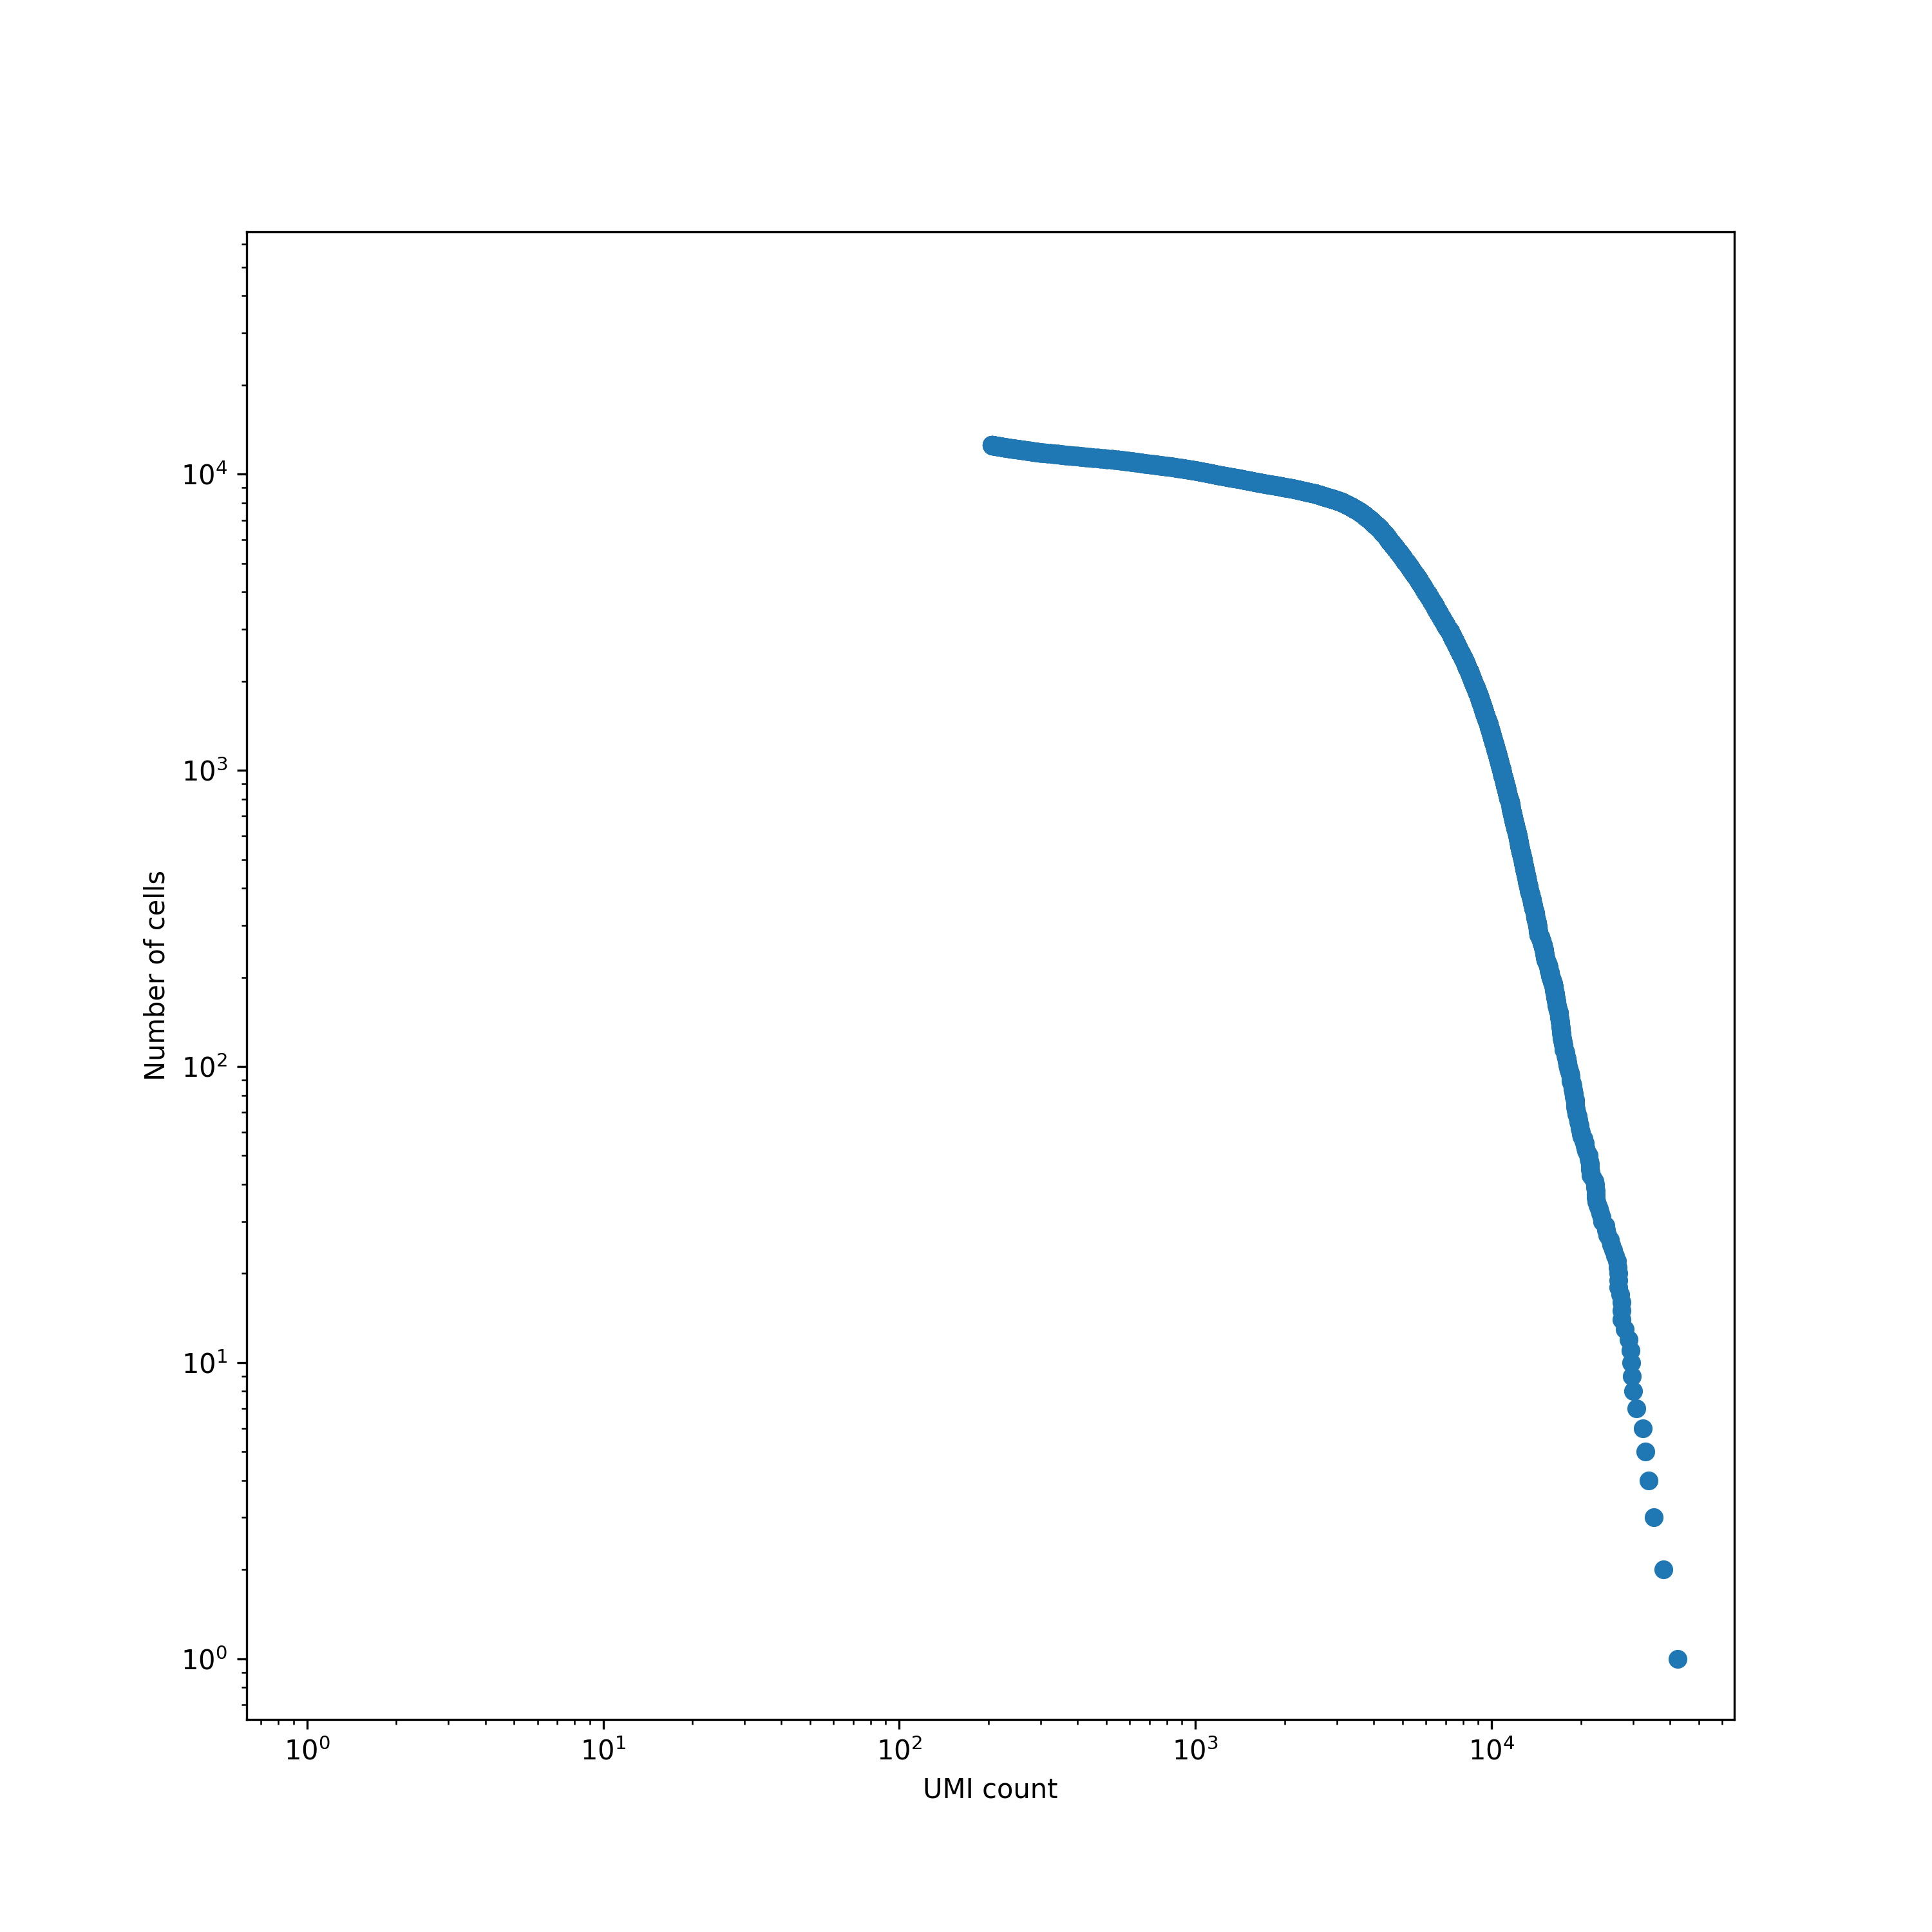

In [19]:
from IPython.display import Image
Image(filename='knee.png')

## Python

You can also make the knee plot from within a python environment

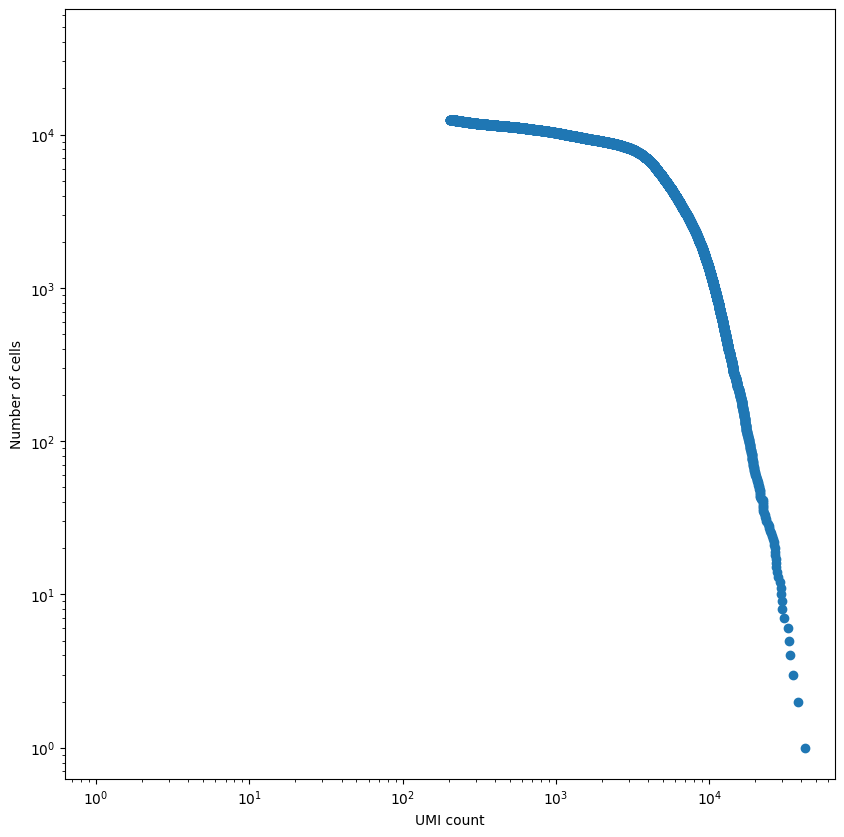

In [22]:
import matplotlib.pyplot as plt
from mx.mx_plot import mx_plot_knee

mtx = mmread("matrix.mtx")

fig, ax = plt.subplots(figsize=(10,10))
ax = mx_plot_knee(mtx, ax)

fig.savefig("knee.png", dpi=300)
fig.show()

In [ ]:
_